In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

#MA model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pmd
from statsmodels.tsa.seasonal import seasonal_decompose


Get data, cleanning it, indexing with dates aggregating sentiment per day and saving it to another dataframe.

In [292]:
data = pd.read_csv('ProjectPH_2013_2021.csv', usecols = [i for i in range(1,7)], index_col=0, parse_dates= True)
data['created'] = pd.to_datetime(data.index)


## ['[effacé]', '[supprimé]', 'Title', 'title', 'Title.'] :(
to_delete = np.array(data.selftext.value_counts().index[0:5])
posts_to_delete_filter = data.selftext.isin(to_delete)
print(f'#deleted: {np.sum(posts_to_delete_filter)}, #rows:{data.shape[0]}, %deleted: {np.sum(posts_to_delete_filter)/data.shape[0]}')
data = data[~posts_to_delete_filter]

# date_time_format = '%Y-%m-%d %H:%M:%S'

## create df per day
dates = np.sort(np.unique(data.created.dt.date))
mean_per_day = data.groupby(data.index.date).mean()

data_per_day = pd.DataFrame({"polarity": mean_per_day.sentiment_polarity, "subjectivity": mean_per_day.sentiment_subjectivity})
data_per_day.index = pd.DatetimeIndex(dates)
data_per_day = data_per_day.asfreq("D", fill_value=0)

data_per_week = data_per_day.groupby(pd.Grouper(freq="W-MON")).mean()
data_per_month = data_per_day.groupby(pd.Grouper(freq="MS")).mean()

print("day: " , data_per_day.head())
print("week:", data_per_week.head())
print("month:", data_per_month.head())

#deleted: 25546, #rows:70143, %deleted: 0.36419885091883725
day:              polarity  subjectivity
2014-01-01 -0.062500      0.187500
2014-01-02  0.055609      0.178205
2014-01-03  0.132031      0.342857
2014-01-04  0.000000      0.000000
2014-01-05  0.000000      0.000000
week:             polarity  subjectivity
2014-01-06  0.020857      0.118094
2014-01-13  0.067488      0.260459
2014-01-20  0.121755      0.424502
2014-01-27  0.108034      0.402589
2014-02-03  0.142838      0.315901
month:             polarity  subjectivity
2014-01-01  0.103327      0.324364
2014-02-01  0.076303      0.241447
2014-03-01  0.080916      0.314551
2014-04-01  0.066695      0.278307
2014-05-01  0.108591      0.300239


Computing mean polarity per day per month, that could be used as prediction or trend for 2022.

In [24]:
month_day_vector = pd.to_datetime([f"2020-{str(month)}-{str(day)}" for day, month in zip(data.index.day, data.index.month)])
month_day_uniques = month_day_vector.unique().sort_values(ascending=1)

polarity_mean_per_day = []
subjectivity_mean_per_day = []
for month_day in month_day_uniques:
    filter_same_month_and_day = np.logical_and(data.index.day == month_day.day, data.index.month ==  month_day.month)
    polarity_mean_per_day.append(np.sum(data[filter_same_month_and_day].sentiment_polarity)/np.sum(filter_same_month_and_day))
    subjectivity_mean_per_day.append(np.sum(data[filter_same_month_and_day].sentiment_subjectivity)/np.sum(filter_same_month_and_day))

# sentiment_per_month = data.sentiment_polarity.groupby(data.index.month).mean()

Plotsss

In [277]:
def plot(x, y, title, show = True, legend = ''):
    plt.plot(x, y)
    plt.title(title)
    if show: plt.show()

def plot_df(df, title_to_add_after_col_name, y_col_names = [], show_every = False, x_col = "index"):
    plt.figure()
    y_col_names = df.columns if y_col_names == [] else y_col_names
    for col_name in y_col_names:
        x = df.index if x_col == "index" else df[x_col]
        plot(x, df[col_name], col_name + " " + title_to_add_after_col_name, show_every)
    if show_every == False:
        plt.title(", ".join(y_col_names) + " " + title_to_add_after_col_name)
    plt.legend(y_col_names)
    if not show_every: plt.show()


In [258]:
", ".join(data_per_month.columns)

'polarity, subjectivity'

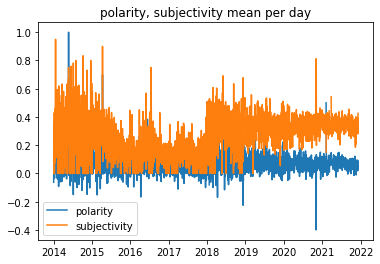

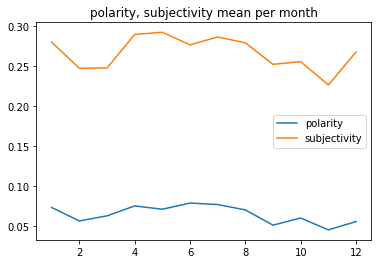

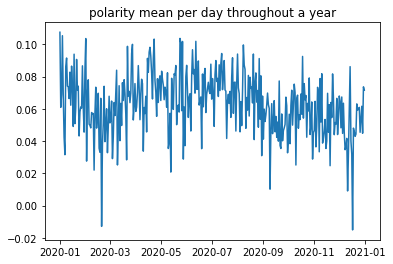

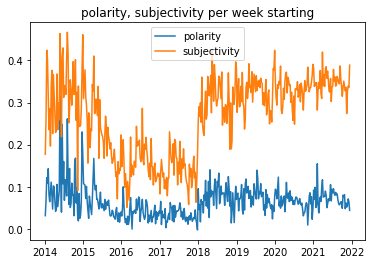

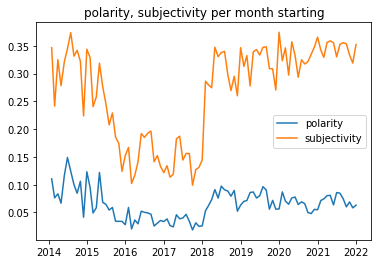

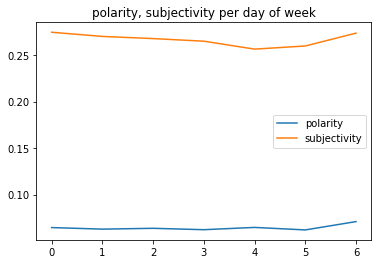

In [278]:
plot_df(data_per_day.groupby(pd.Grouper(freq="D")).mean(), "mean per day" )

plot_df(data_per_day.groupby(data_per_day.index.month).mean(), "mean per month")

plot(month_day_uniques, polarity_mean_per_day, "polarity mean per day throughout a year")
# plot(month_day_uniques, subjectivity_mean_per_day, "subjectivity pred mean per day")


plot_df(data_per_day.groupby(pd.Grouper(freq="W-MON")).mean(), "per week starting")
plot_df(data_per_day.groupby(pd.Grouper(freq="M")).mean(), "per month starting")
plot_df(data_per_day.groupby(data_per_day.index.weekday).mean(), 'per day of week')


Most usefull plots

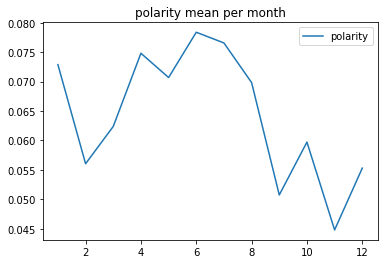

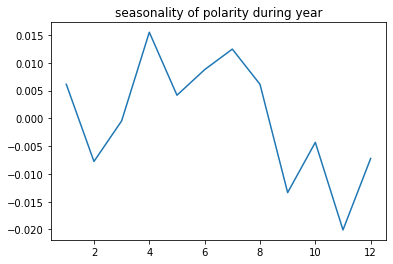

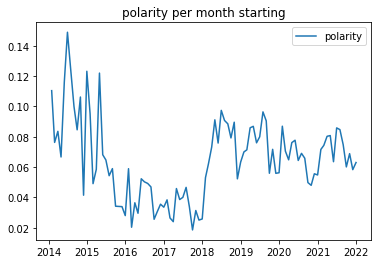

In [279]:
t = seasonal_decompose(data_per_month.polarity, model='additive')
plot_df(data_per_day.groupby(data_per_day.index.month).mean(), "mean per month", y_col_names=["polarity"])

t.seasonal.groupby(t.seasonal.index.month).mean().plot(title="seasonality of polarity during year")
plt.plot()

plot_df(data_per_day.groupby(pd.Grouper(freq="M")).mean(), "per month starting", y_col_names= ['polarity'])

Let's define the steps we'll use:

        First run test and deduce which model to use
        Then fit models
        visualize again the data and predictions

In [296]:
def run_tests(time_serie):
    ad_res = adfuller(time_serie)
    print(ad_res[:4])
    while ad_res[1] > 0.1:
        time_serie = time_serie.diff()[1:]
        ad_res = adfuller(time_serie)
        print(ad_res[:4])
    
    plot_acf(time_serie, lags=40)
    plt.show()
    plot_pacf(time_serie, lags=40, method = "ywm")
    plt.show()

    seasonal_decompose(time_serie, model='additive').plot()
    plt.show()

    res = pmd.auto_arima(time_serie, start_p=1, start_q=1, test="adf", trace=True)
    print(res.summary())

def fit_models(model_names, time_serie):
    models = {}
    for model_name in model_names:
        model_type, parameters = model_name.split()
        if model_type.lower() == "arima":
            models[model_name] = ARIMA(time_serie, order =  tuple(int(e) for e in parameters)).fit()
        if model_type.lower() == "sarimax":
            models[model_name] = SARIMAX(time_serie, order =  tuple(int(e) for e in parameters)).fit()
    return models


def model_visualization(models, time_serie, pred_after_end = 5, get_res = 0):
    start, end = 0, len(time_serie)
    start_pred, end_pred = len(time_serie), len(time_serie) + pred_after_end

    data = {time_serie.name: time_serie}
    pred_data = {}
    for model_name, model in models.items():
        data[model_name] = model.predict(start, end)
        pred_data[model_name] = model.predict(start_pred, end_pred)

    data = pd.DataFrame(data)
    pred_data = pd.DataFrame(pred_data)
    
    data.plot(figsize=(10, 6))
    plt.plot()
    pred_data.plot(figsize=(10, 6))
    plt.plot()
    if get_res:
        return data, pred_data


Working on data_per_day

(-5.420852647420411, 3.0618372183052073e-06, 28, 2870)


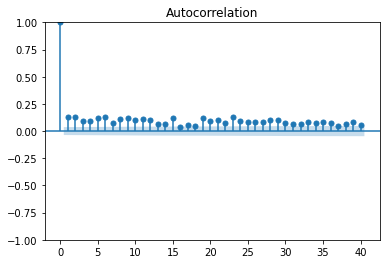

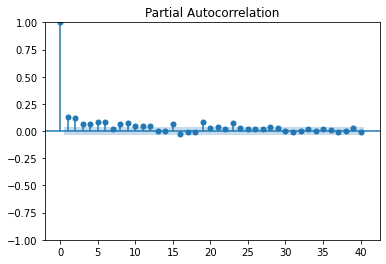

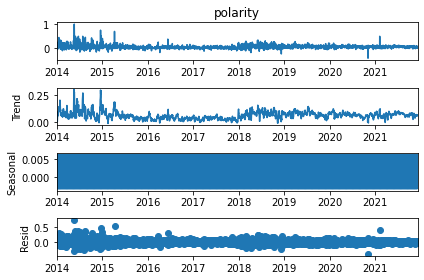

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7273.350, Time=4.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-7065.884, Time=0.43 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-7110.820, Time=0.68 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-7101.961, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5374.308, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-7223.742, Time=3.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-7235.538, Time=3.28 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-7135.435, Time=1.33 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-7148.199, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-7266.064, Time=3.54 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7274.209, Time=1.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5884.640, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6258.791, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-7275.413, Time=1.60 sec
 ARIMA(2,0,0)(0,0,0

In [293]:
run_tests(data_per_day.polarity)

In [ ]:
fitted_models_day = fit_models(["arima 401", "arima 301", "arima 202"], data_per_day.polarity)

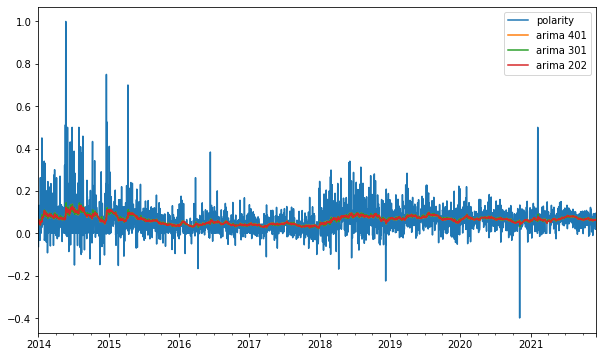

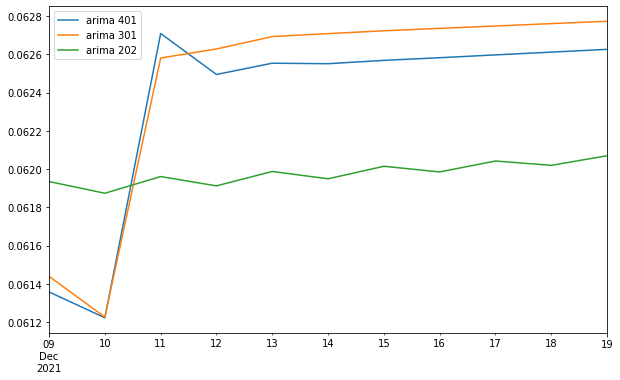

In [299]:
model_visualization(fitted_models_day, data_per_day.polarity, 10)

    Working on data_per_week

In [ ]:
run_tests(data_per_week.polarity)

In [281]:
fitted_models_week = fit_models(["arima 101", "arima 102", "arima 201", "arima 100"], data_per_week.polarity)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


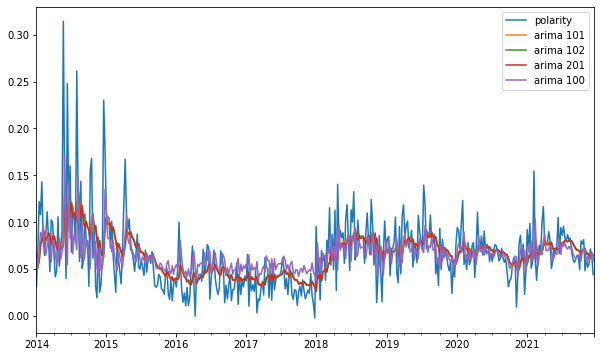

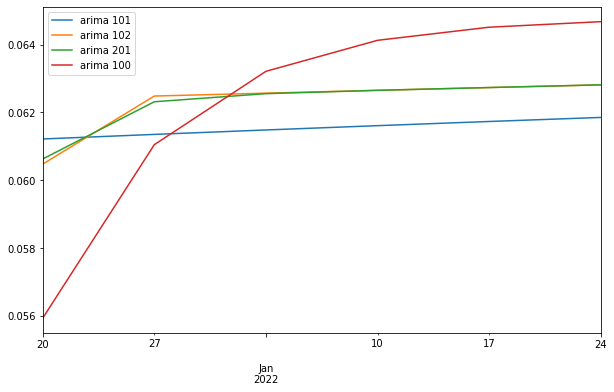

In [283]:
model_visualization(fitted_models_week, data_per_week.polarity)

    Working on data_per_month

(-2.489307997682093, 0.11809752555751907, 4, 91)
(-4.321530536729175, 0.00040758422932320415, 7, 87)


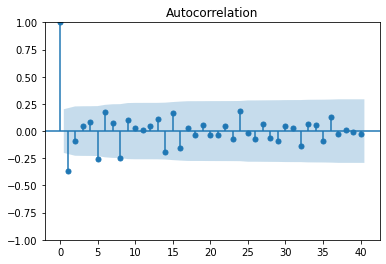

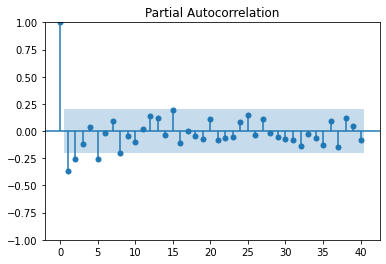

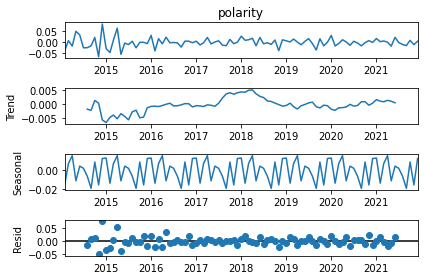

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-476.488, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-457.215, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-469.419, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-477.882, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-459.163, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-476.490, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-474.255, Time=0.37 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-479.719, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-478.210, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-478.306, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-471.335, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-476.093, Time=0.24 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.744 seconds
                               SARIMAX Results                                
Dep. Vari

In [284]:
run_tests(data_per_month.polarity)

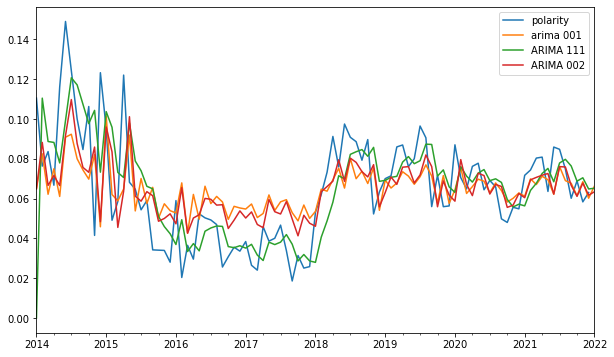

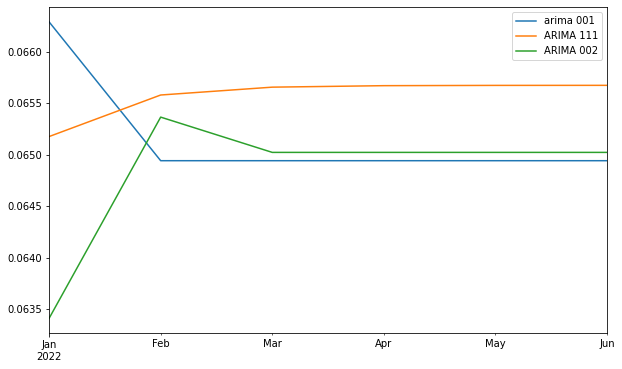

In [286]:
models_to_fit = ["arima 001", "ARIMA 111", "ARIMA 002"]
fitted_models_month = fit_models(models_to_fit, data_per_month.polarity)
model_visualization(fitted_models_month, data_per_month.polarity)